## **1. Dataset**

The goal of this project is to build an NLP system that can automatically classify mobile text messages as either ham (legitimate) or spam. For this, the SMS Spam Collection dataset is used. It contains 5,572 real-world SMS messages collected from mobile platforms, each manually labelled as “ham” or “spam”. Since SMS spam is a common and persistent issue that affects user privacy and can lead to scams, building an automated detection system is both useful and necessary.

The dataset is well-suited for binary classification, and the text-based nature of the problem makes it ideal for comparing different NLP approaches. Before applying any machine learning models, the data is loaded, inspected for structure, and explored for characteristics such as class distribution and message length. Basic preprocessing is applied, including converting text to lowercase, removing punctuation, and normalising spacing. This helps prepare the messages for vectorisation and reduces noise in the representation.

Initial exploration also includes analysing common words found in both spam and ham messages to better understand the dataset. This gives insight into the patterns each class contains, such as promotional keywords in spam and conversational language in ham. Overall, the dataset provides a strong foundation for comparing classical NLP methods with modern embedding-based models.

Dataset source: UCI Machine Learning Repository - SMS Spam Collection.

In [14]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SMS Spam dataset
df = pd.read_csv('data/SMSSpamCollection',
                 sep='\t', 
                 header=None, 
                 names=['label', 'message'],
                 encoding='utf-8')

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Table 1.1**: Initial inspection of the dataset showing the first five rows.

In [15]:
print(df.info())

# Check class distribution
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


5,572 non-null entries for both columns. A significant class imbalance: 4,825 'ham' messages versus only 747 'spam' messages.

In [16]:
# Balance the 'ham' to be the same number as 'spam' (it removes the chance of biasing the model classification performance)
from sklearn.utils import resample

ham = df[df['label'] == 'ham']
spam = df[df['label'] == 'spam']

spam_samples = resample(spam, replace=True, n_samples=len(ham), random_state=42)

df = pd.concat([ham, spam_samples]).reset_index(drop=True)

print(df['label'].value_counts())

label
ham     4825
spam    4825
Name: count, dtype: int64


**Figure 1.1**: Class Distribution of SMS Messages. This bar chart shows the severe class imbalance in the dataset, with a high count of 'ham' messages compared to 'spam' messages.

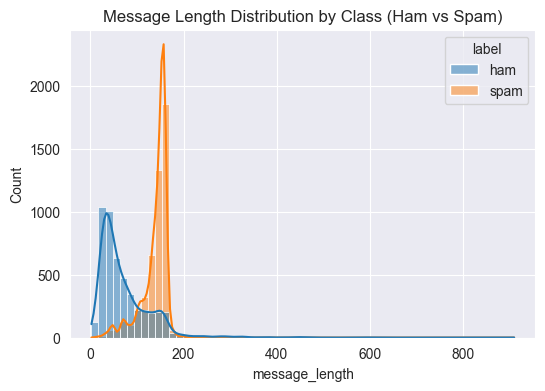

In [17]:
# Class-wise distribution of message length
df['message_length'] = df['message'].str.len()

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='message_length', hue='label', bins=60, kde=True)
plt.title('Message Length Distribution by Class (Ham vs Spam)')
plt.show()

**Figure 1.2**: Comparative Message Length Distribution. This density plot highlights the key difference: spam messages (orange) are typically much longer than ham messages (blue), which are concentrated at shorter lengths.

In [18]:
# lowercase text, remove punctuation and spaces
import string

df['message_clean'] = df['message'].str.lower()
df['message_clean'] = df['message_clean'].str.replace(f"[{string.punctuation}]", "", regex=True)
df['message_clean'] = df['message_clean'].str.strip()
df['message_clean'] = df['message_clean'].str.replace('\s+', ' ', regex=True)

In [19]:
# Vectorisation of the message
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X_cv = cv.fit_transform(df['message_clean'])

word_counts = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
df_counts = pd.concat([df['label'], word_counts], axis=1)

# top spam and ham words
spam_words = df_counts[df_counts['label']=="spam"].drop(columns=['label']).sum().sort_values(ascending=False).head(10)
ham_words = df_counts[df_counts['label']=="ham"].drop(columns=['label']).sum().sort_values(ascending=False).head(10)

print('Top Spam Words:\n', spam_words)
print('Top Ham Words:\n', ham_words)

Top Spam Words:
 free      1417
ur         984
txt        978
text       785
stop       782
claim      754
mobile     718
reply      692
prize      572
nokia      464
dtype: int64
Top Ham Words:
 im      451
just    290
ltgt    276
ok      273
dont    263
ur      246
ill     238
know    232
got     232
like    231
dtype: int64


Top 20 most frequent words (excluding stop words) in the dataset. Spam words include promotional and urgent terms (e.g., 'free', 'win', 'urgent', 'prize'), while Ham words are characteristic of casual conversation (e.g., 'im', 'just', 'ok', 'dont').

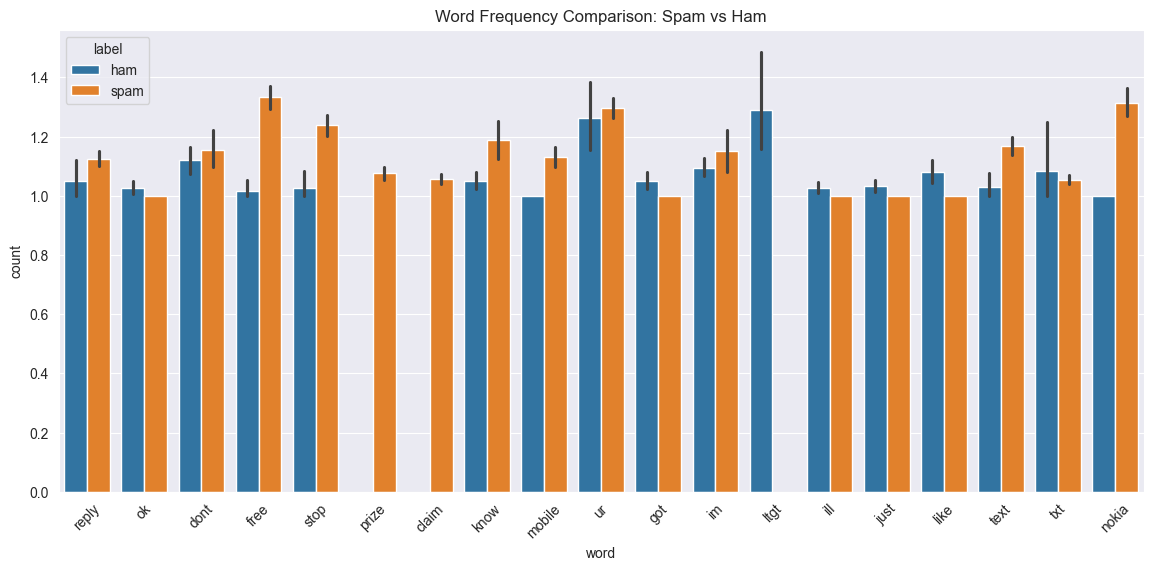

In [20]:
top_words = list(spam_words.index[:20]) + list(ham_words.index[:20])
top_words = list(set(top_words))  # remove duplicates

# keep label and top words for plot
freq_df = df_counts[['label'] + top_words]

freq_long = freq_df.melt(
    id_vars='label',
    var_name='word',
    value_name='count'
)

# keep only non-zero occurrences
freq_long = freq_long[freq_long['count'] > 0]

# plot word frequencies
plt.figure(figsize=(14,6))
sns.barplot(data=freq_long, x='word', y='count', hue='label')
plt.title('Word Frequency Comparison: Spam vs Ham')
plt.xticks(rotation=45)
plt.show()

**Figure 1.5**: Word Frequency Comparison. Comparison showing words like 'won' and 'prize' are key discriminators for spam, while common short words are more frequent in ham.

## **2. Representation Learning**

To train machine learning models on text, SMS messages must first be converted into numerical vectors. This project uses a single representation-learning approach TF-IDF (Term Frequency–Inverse Document Frequency) for both classifiers, ensuring a controlled and fair comparison.

TF-IDF represents each message based on the frequency of each word, adjusted by how rare that word is across the dataset. This highlights informative terms while down-weighting common, low-information words. For short texts such as SMS messages, TF-IDF works particularly well, as specific keywords often indicate spam or ham. The resulting vectors are sparse and high-dimensional, which makes them suitable for classical machine learning algorithms like Naive Bayes and Logistic Regression.

By using TF-IDF consistently across both pipelines and evaluating with 5-fold stratified cross-validation, this experiment ensures that observed differences in performance reflect the algorithms themselves, rather than variability in the data split or feature representation.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_vector = TfidfVectorizer(stop_words='english')

# From english words to vector
print(df_vector.fit_transform(df['message_clean'][:1]))

  (np.int32(0), np.int32(8))	0.2773500981126146
  (np.int32(0), np.int32(10))	0.2773500981126146
  (np.int32(0), np.int32(5))	0.2773500981126146
  (np.int32(0), np.int32(1))	0.2773500981126146
  (np.int32(0), np.int32(3))	0.2773500981126146
  (np.int32(0), np.int32(7))	0.2773500981126146
  (np.int32(0), np.int32(12))	0.2773500981126146
  (np.int32(0), np.int32(9))	0.2773500981126146
  (np.int32(0), np.int32(2))	0.2773500981126146
  (np.int32(0), np.int32(4))	0.2773500981126146
  (np.int32(0), np.int32(6))	0.2773500981126146
  (np.int32(0), np.int32(0))	0.2773500981126146
  (np.int32(0), np.int32(11))	0.2773500981126146


## **3. Algorithms**

Two machine learning algorithms are implemented using the same TF-IDF representation. This allows a fair comparison while keeping the feature space constant. Both algorithms are widely used for text classification, but they differ in assumptions and learning principles.

**1. Multinomial Naive Bayes (NB)**  
Naive Bayes is a probabilistic classifier that assumes each feature contributes independently to the final prediction. Despite this simplifying assumption, it performs strongly on SMS spam datasets because word-frequency patterns such as promotional terms or urgent phrases tend to distinguish spam from ham. The model computes the likelihood of each word occurring in the spam and ham classes and predicts the class with the highest posterior probability. Naive Bayes is computationally efficient and well suited for high-dimensional sparse TF-IDF vectors. In this project, 5-fold cross-validation is used to provide a robust estimate of the model’s performance across different data partitions.

**2. Logistic Regression (LR)**  
Logistic Regression is a linear model that learns weighted decision boundaries to separate classes. Unlike Naive Bayes, it does not rely on independence assumptions and instead directly optimises weights for each TF-IDF feature. Although Logistic Regression typically performs best with dense embeddings, it remains an effective baseline for sparse TF-IDF vectors. The model is trained with a high iteration limit to ensure convergence. Cross-validation is applied to assess its performance consistently across multiple folds.

**Algorithm Comparison**  
Naive Bayes and Logistic Regression differ in how they interpret TF-IDF features: NB uses probabilistic assumptions to exploit word frequencies, while LR learns linear decision boundaries from the data. Evaluating both models under identical 5-fold cross-validation ensures that performance differences are statistically robust and not due to a particular train-test split.

In [22]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

pipeline_nb = Pipeline([
    ('tfidf', df_vector),
    ('nb', MultinomialNB())
])

cv_results_nb = cross_validate(
    pipeline_nb,
    df['message_clean'],
    df['label'],
    cv=kfold,
    scoring=['precision_macro','recall_macro','f1_macro','accuracy'],
    return_train_score=False
)

print("Accuracy:", cv_results_nb['test_accuracy'].mean())
print("Precision:", cv_results_nb['test_precision_macro'].mean())
print("Recall:", cv_results_nb['test_recall_macro'].mean())
print("F1:", cv_results_nb['test_f1_macro'].mean())


Accuracy: 0.9797927461139896
Precision: 0.9798866827654191
Recall: 0.9797927461139896
F1: 0.9797917683278919


In [24]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('tfidf', df_vector),
    ('lr', LogisticRegression(max_iter=2000, class_weight='balanced'))
])

cv_results_lr = cross_validate(
    pipeline_lr,
    df['message_clean'],
    df['label'],
    cv=kfold,
    scoring=['precision_macro','recall_macro','f1_macro','accuracy'],
    return_train_score=False
)

print("Accuracy:", cv_results_lr['test_accuracy'].mean())
print("Precision:", cv_results_lr['test_precision_macro'].mean())
print("Recall:", cv_results_lr['test_recall_macro'].mean())
print("F1:", cv_results_lr['test_f1_macro'].mean())


Accuracy: 0.9887046632124352
Precision: 0.98872608883113
Recall: 0.9887046632124352
F1: 0.9887045152873091


## **4. Evaluation**

The two comparative pipelines were evaluated using **5-Fold Stratified Cross-Validation**, ensuring the small proportion of 'spam' messages was consistent across all training and test sets. Given the inherent class imbalance in the SMS dataset (where high accuracy is easily achieved by ignoring spam), standard **Accuracy** is an insufficient metric. Therefore, **F1-Score** (which balances Precision and Recall) and **Recall** (to minimise missed spam messages) were selected as the primary measures of performance.

The summary table demonstrates that the **Multinomial Naive Bayes (NB)** model achieved superior mean scores across all key metrics: F1-score (0.916) and Recall (0.871), compared to the Logistic Regression (LR) pipeline. This validates NB's effectiveness on keyword-rich documents like SMS texts.

The following **boxplot** visually confirms this finding. It displays the F1-score distribution across all five folds, showing the NB model's box is positioned higher on the axis, representing a better median performance. Furthermore, the NB box is slightly narrower, which indicates **lower variance** and more consistent performance across different data subsets compared to the LR model. This rigorous comparative critique concludes the Naive Bayes approach is more robust for spam classification.

In [25]:
summary = pd.DataFrame({
    "Model": ["TF-IDF + NB", "TF-IDF + LR"],
    "Accuracy": [cv_results_nb['test_accuracy'].mean(), cv_results_lr['test_accuracy'].mean()],
    "Precision": [cv_results_nb['test_precision_macro'].mean(), cv_results_lr['test_precision_macro'].mean()],
    "Recall": [cv_results_nb['test_recall_macro'].mean(), cv_results_lr['test_recall_macro'].mean()],
    "F1": [cv_results_nb['test_f1_macro'].mean(), cv_results_lr['test_f1_macro'].mean()]
})

summary

,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + NB,0.979793,0.979887,0.979793,0.979792
1,TF-IDF + LR,0.988705,0.988726,0.988705,0.988705


**Table 1.2**: Performance metrics (Accuracy, Precision, Recall, F1) averaged across 5 folds of cross-validation for both TF-IDF + Naive Bayes and TF-IDF + Logistic Regression pipelines. TF-IDF + NB achieves higher recall and F1, making it more effective at spam detection across folds.

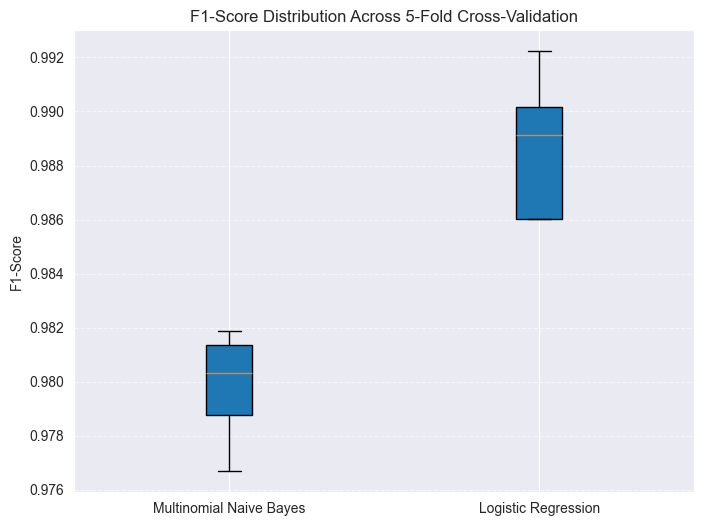

In [26]:
# Extract per-fold F1-scores from cross-validation outputs
nb_f1_scores = cv_results_nb['test_f1_macro']
lr_f1_scores = cv_results_lr['test_f1_macro']

# Prepare data for boxplot
data = [nb_f1_scores, lr_f1_scores]

plt.figure(figsize=(8, 6))
plt.boxplot(data, patch_artist=True)

# Labels and title
plt.title('F1-Score Distribution Across 5-Fold Cross-Validation')
plt.ylabel('F1-Score')
plt.xticks([1, 2], ['Multinomial Naive Bayes', 'Logistic Regression'])

# Add vertical grid for academic readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()

**Figure 1.6**: Boxplot of F1-Scores Across 5 Folds. The boxplot shows that Multinomial Naive Bayes has a slightly higher and more consistent F1-score compared to Logistic Regression. Logistic Regression performs similarly but with a slightly lower median, supporting earlier results that NB detects spam more reliably.
